In [1]:
import os
import pickle
import random
import glob
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy import stats
from IPython.display import HTML
from scipy.io import loadmat
from matplotlib.animation import FuncAnimation
import seaborn as sn
from mpl_toolkits import mplot3d
from itertools import compress
from mpl_toolkits.mplot3d import Axes3D
import random
import multiprocessing
from multiprocessing import cpu_count, Pool
from joblib import Parallel, delayed
from utils import *
from pathlib import Path


NumThread=(multiprocessing.cpu_count()-1)*2 # sets number of workers based on cpus on current machine


In [3]:
def load(mat_file = '', channels = [130,131]):
    # Load the .mat file
    mat = loadmat(mat_file)
    # Extract the saccade_data cell array. Note that this will be a structured numpy array.
    saccade_data = mat[list(mat.keys())[-1]][0]
    
    #selectively return the channels of interest ommitting all other
    extracted_saccades=[]
    for saccade in saccade_data:
        channel_sacs = []
        for channel in channels:
            channel_sacs.append( np.ndarray.tolist(saccade[channel]) )
        extracted_saccades.append(np.array(channel_sacs))
    return extracted_saccades
def normalize(saccades):
    for i in range(len(saccades)):
        for j in range(len(saccades[i])):
            saccades[i][j] = (saccades[i][j]-np.mean(saccades[i][j]))/np.std(saccades[i][j])
    return saccades
def car_to_polar(saccades):
    for i in range(len(saccades)):
        x=saccades[i][0]
        y=saccades[i][1]
        rho=np.sqrt(x**2+y**2)
        phi=np.arctan2(y,x)
        saccades[i]=np.array([rho,phi])
    return saccades

In [ ]:
#  mat file
mat_file_path = '/mnt/home/mplomecka/saccades/data/newdata/filteredData_antiright_young.mat'
sac_pos = load(mat_file_path)
random.shuffle(sac_pos)

In [ ]:

# scales and Ts
scales = np.array([0.006, 0.008, 0.01])
Ts = np.array([3,4,5])

In [4]:
def process_trajectories(batch_num, sac_pos, scales, Ts):
    trajectories=[]
    for sac in sac_pos[:50]:
        trajectories.append(sac[0])

    Ts_p = np.flip(np.tile(Ts, len(scales)))
    scales_p = np.repeat(scales, len(Ts), axis=0)

    with tqdm_joblib(tqdm(desc=f"FTLEs, Batch {batch_num}", total=len(Ts_p))) as progress_bar:
        results = Parallel(n_jobs=cpu_count())(
            delayed(compute_FTLEs_parallel)(trajectories, scale=scale, T=T, delay_dimension=5, num_singular_vectors=3)
            for T, scale in zip(Ts_p, scales_p)
        )
    all_ftles = {}
    for i, (T, scale) in enumerate(zip(Ts_p, scales_p)):
        all_ftles[(T, scale)] = results[i]

    filename_mat = Path(mat_file_path).stem  # name without extension
    filename_parts = filename_mat.split('_')  
    filename_pickle = '_'.join(filename_parts[-2:]) + f'_batch_{batch_num}.pickle'  

    save_dir = './generated_results'
    os.makedirs(save_dir, exist_ok=True)
    file_path = os.path.join(save_dir, filename_pickle)

    # saving the all_ftles dictionary into a pickle file - check with Guys if that's ok
    with open(file_path, 'wb') as handle:
        pickle.dump(all_ftles, handle, protocol=pickle.HIGHEST_PROTOCOL)

    print(f"All_ftles saved in {file_path}")


with Pool(processes=NumThread) as pool:  
    pool.starmap(process_trajectories, [(i, sac_pos, scales, Ts) for i in range(4)])  # 4 batches


FTLEs, Batch 3:   0%|          | 0/9 [00:00<?, ?it/s]/mnt/sw/nix/store/b4q5asj8flwlgmaijgj1r6wbmnls5x8k-python-3.9.15-view/lib/python3.9/site-packages/joblib/parallel.py:775: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = self._backend.configure(n_jobs=self.n_jobs, parallel=self,
/mnt/sw/nix/store/b4q5asj8flwlgmaijgj1r6wbmnls5x8k-python-3.9.15-view/lib/python3.9/site-packages/joblib/parallel.py:775: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = self._backend.configure(n_jobs=self.n_jobs, parallel=self,
/mnt/sw/nix/store/b4q5asj8flwlgmaijgj1r6wbmnls5x8k-python-3.9.15-view/lib/python3.9/site-packages/joblib/parallel.py:775: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = self._backend.configure(n_jobs=self.n_jobs, parallel=self,
/mnt/sw/nix/store/b4q5asj8flwlgmaijgj1r6wbmnls5x8k-python-3.9.15-view/lib/python3.9

All_ftles saved in ./generated_results/antiright_young_batch_1.pickle


FTLEs, Batch 2: 100%|██████████| 9/9 [12:34<00:00, 83.83s/it]


All_ftles saved in ./generated_results/antiright_young_batch_2.pickle


FTLEs, Batch 0: 100%|██████████| 9/9 [13:04<00:00, 87.12s/it]


All_ftles saved in ./generated_results/antiright_young_batch_0.pickle


FTLEs, Batch 3: 100%|██████████| 9/9 [13:31<00:00, 90.15s/it]


All_ftles saved in ./generated_results/antiright_young_batch_3.pickle


In [5]:
#load all pickles and concatenate them!
dir = './generated_results'
filename_pattern = 'antiright_young_batch_*.pickle'  

all_ftles = {}

for filename in glob.glob(os.path.join(dir, filename_pattern)):
    with open(filename, 'rb') as handle:
        batch_ftles = pickle.load(handle)
        all_ftles.update(batch_ftles)


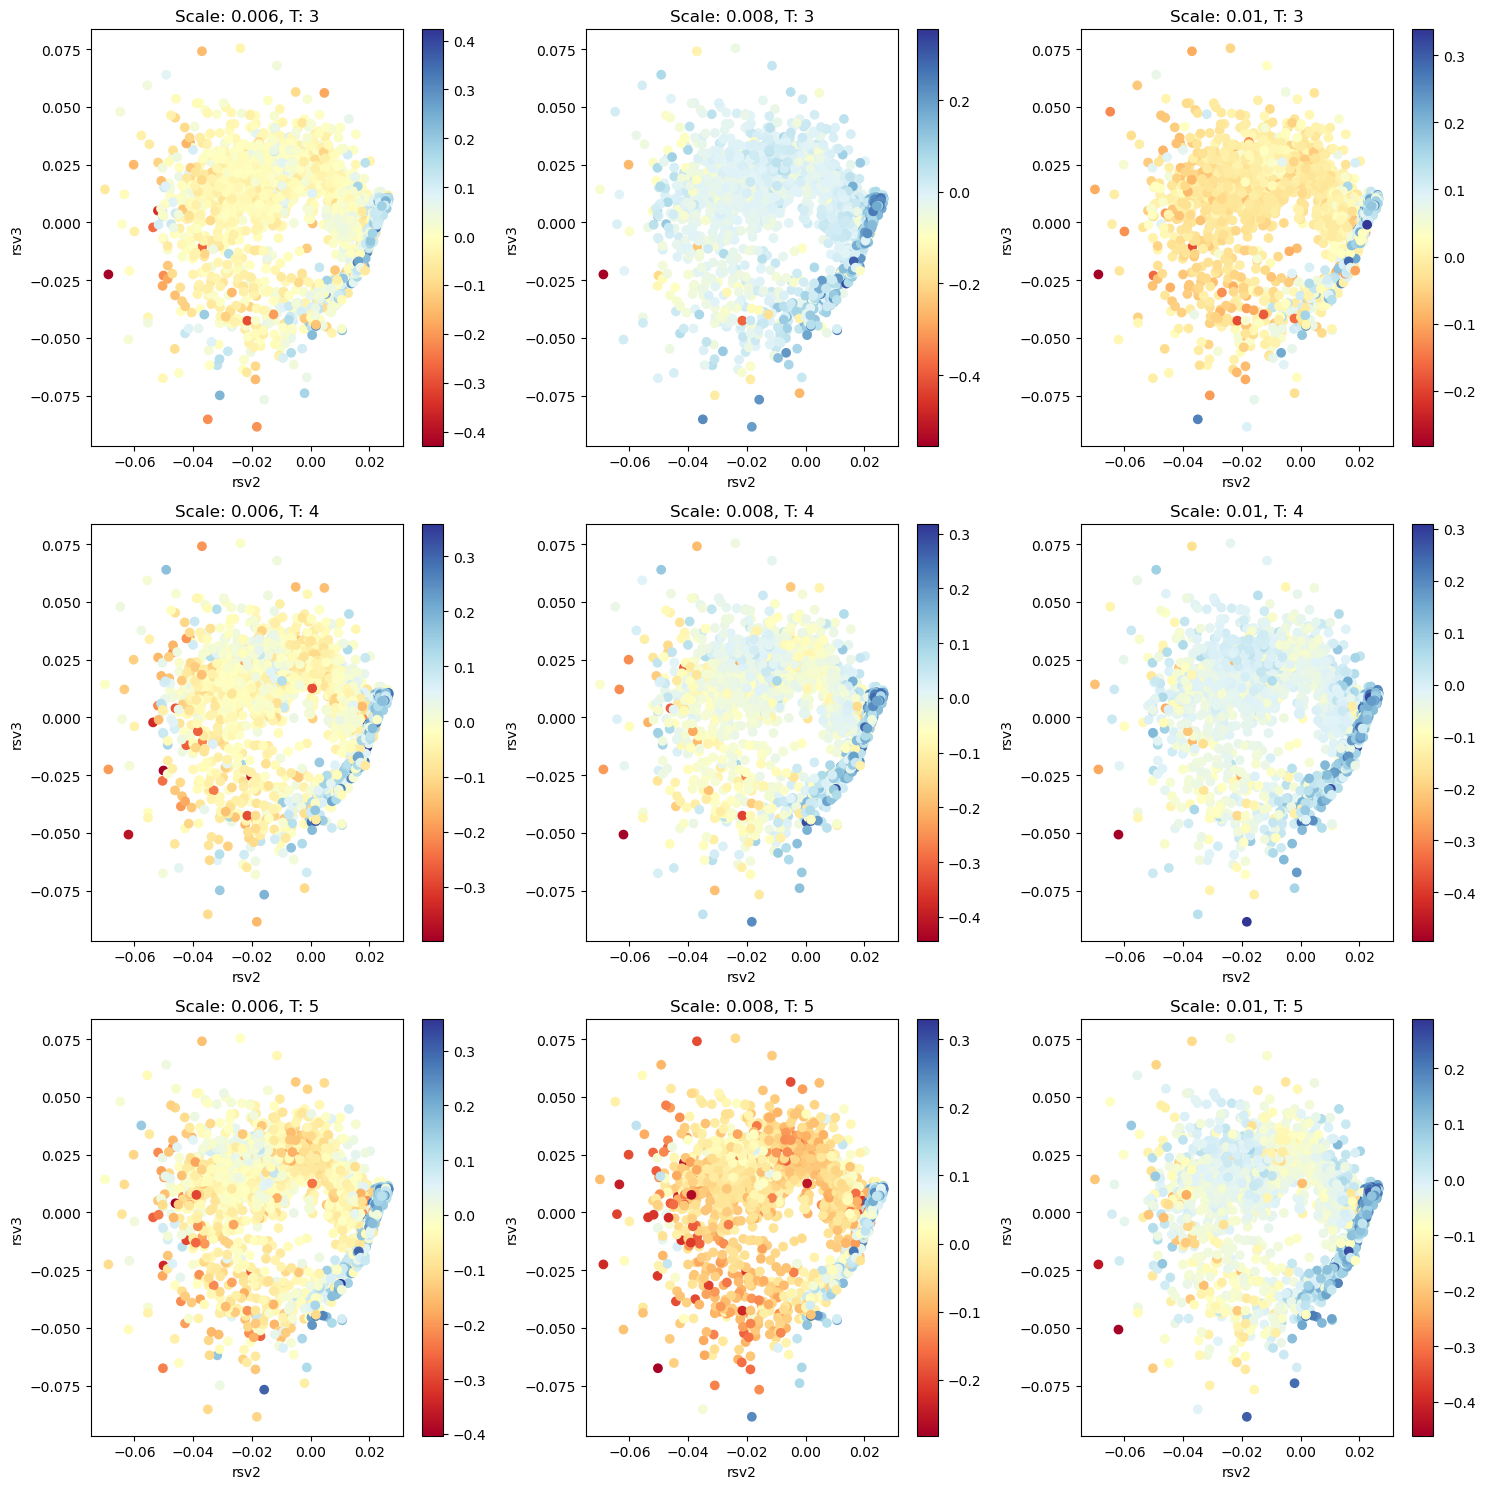

In [6]:
fig = plt.figure(figsize=(15, 15))

cm = plt.cm.get_cmap('RdYlBu')

plot_index = 1
m=45*20

for T in Ts:
    for scale in scales:
        vc = all_ftles[(T, scale)]['vc']
        les = all_ftles[(T, scale)]['les_vc'][:,1]
        # Create a subplot for the current scale and T
        ly_dir = all_ftles[(T, scale)]['lyv_vc'][2,:]
        ax = fig.add_subplot( len(Ts), len(scales), plot_index)
        p = ax.scatter(vc[1], vc[2], c=les, cmap=cm)
        #p = ax.quiver(vc[1][:m], vc[2][:m], ly_dir[1][:m], ly_dir[2][:m],color=cm(les[:m]), scale=20)
        ax.set_xlabel('rsv2')
        ax.set_ylabel('rsv3')
        ax.set_title(f'Scale: {scale}, T: {T}')
        fig.colorbar(p, ax=ax)
        
        plot_index += 1

plt.tight_layout()
plt.show()
